In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import datetime
import sklearn
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import statsmodels.api as sm
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras import Sequential, regularizers
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Add, Attention, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

2025-11-14 07:52:21.628429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763106741.879843      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763106741.951364      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
def conditional_interpolate(s: pd.Series):
    s = s.copy()
    n = len(s)

    # Fill missing values at the beginning with backward fill
    if pd.isna(s.iat[0]):
        s = s.bfill(limit=1)

    # Fill missing values at the end with forward fill
    if pd.isna(s.iat[-1]):
        s = s.ffill(limit=1)

    i = 1
    while i < n:
        if pd.isna(s.iat[i]):
            start = i
            j = i + 1
            while j < n and pd.isna(s.iat[j]):
                j += 1
            end = j

            left = start - 1
            right = end

            interp_idx = []
            if left >= 0:
                interp_idx.append(left)
            interp_idx.extend(range(start, end))
            if right < n:
                interp_idx.append(right)

            temp = s.iloc[interp_idx].copy()
            known_points = temp.notna().sum()

            if known_points >= 3:
                method = 'spline'
                order = 2
                sub = temp.interpolate(method=method, order=order, limit_direction='both')
            elif known_points >= 1:
                method = 'linear'
                order = None
                sub = temp.interpolate(method=method, limit_direction='both')
            else:
                i = end
                continue

            for k, orig_idx in enumerate(interp_idx):
                s.iat[orig_idx] = sub.iat[k]

            i = end
        else:
            i += 1

    return s


In [3]:
def clean_time_series_with_autoencoder(df: pd.DataFrame, autoencoder: Model, threshold: float = None, scale: bool = True):

    cleaned_states = []

    states = df['state_name'].unique().tolist()
    for s in states:
        df_state = df[df['state_name'] == s].copy()

        numeric_cols = df_state.select_dtypes(include='float64').columns.tolist()
        df_numeric = df_state[numeric_cols]

        if scale:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(df_numeric)
        else:
            X_scaled = df_numeric.values

        reconstructed = autoencoder.predict(X_scaled)
        reconstruction_error = np.mean(np.square(X_scaled - reconstructed), axis=1)

        local_threshold = threshold if threshold is not None else np.percentile(reconstruction_error, 95)
        anomaly_mask = reconstruction_error > local_threshold

        for col in numeric_cols:
            df_state.loc[anomaly_mask, col] = conditional_interpolate(df_state.loc[anomaly_mask, col])

        cleaned_states.append(df_state)

    cleaned_df = pd.concat(cleaned_states, ignore_index=True)
    return cleaned_df
def build_autoencoder(input_dim: int) -> Model:
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    return Model(inputs=input_layer, outputs=output_layer)



In [4]:
def create_sequences(X, y, window):
    X_seq, y_seq = [], []
    print("len(X):", len(X), "len(y):", len(y), "window:", window)
    if window <= 0:  # Handle window size of 0
        window = 1
    for i in range(len(X) - window):

        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

In [5]:
# Load dataset

crop = pd.read_csv('/kaggle/input/dataset-wheat/merged_wheat_reservoir.csv')

In [6]:
# Preprocessing
crop['temperature_recorded_date'] = pd.to_datetime(crop['temperature_recorded_date'])
crop['year'] = crop['temperature_recorded_date'].dt.year
crop['month'] = crop['temperature_recorded_date'].dt.month
crop['day'] = crop['temperature_recorded_date'].dt.dayofyear
null_cols = crop.columns[crop.isnull().any()].tolist()
states = crop['state_name'].unique().tolist()
for s in states:
    mask = crop['state_name'] == s
    for col in null_cols:
        crop.loc[mask, col] = conditional_interpolate(crop.loc[mask, col])
autoencoder = build_autoencoder(input_dim=crop.shape[1]-7)
autoencoder.compile(optimizer='adam', loss='mse')
crops = clean_time_series_with_autoencoder(crop, autoencoder)

I0000 00:00:1763106759.231496      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763106759.232258      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [7]:
scol = ['Live Cap FRL', 'Level', 'Current Live Storage', 'yield' ]
for s in states:
    mask = crops['state_name'] == s
    for c in scol:
        series_to_process = crops.loc[mask, c]
        if len(series_to_process) >= 2 * 365:
            result = sm.tsa.seasonal_decompose(series_to_process, model = 'additive', period = 365)
            crops.loc[mask, c] = result.trend + result.seasonal
            crops.loc[mask, c] = conditional_interpolate(crops.loc[mask, c])
        else:
            print(f"Skipping seasonal decomposition for state '{s}', column '{c}' due to insufficient data ({len(series_to_process)} observations). Applying conditional interpolation directly.")
            crops.loc[mask, c] = conditional_interpolate(series_to_process)

Skipping seasonal decomposition for state 'Tamil Nadu', column 'Live Cap FRL' due to insufficient data (366 observations). Applying conditional interpolation directly.
Skipping seasonal decomposition for state 'Tamil Nadu', column 'Level' due to insufficient data (366 observations). Applying conditional interpolation directly.
Skipping seasonal decomposition for state 'Tamil Nadu', column 'Current Live Storage' due to insufficient data (366 observations). Applying conditional interpolation directly.
Skipping seasonal decomposition for state 'Tamil Nadu', column 'yield' due to insufficient data (366 observations). Applying conditional interpolation directly.


In [8]:
crop = crops.groupby(['state_name', 'year', 'day']).agg({
    'month' : 'first',
    'state_temperature_max_val': 'first',
    'state_temperature_min_val': 'first',
    'state_rainfall_val': 'first',
    'FRL': 'first',
    'Live Cap FRL': 'first',
    'Level': 'first',
    'Current Live Storage': 'first',
}).reset_index()
feature_cols = crop.select_dtypes(include = 'float64').columns.tolist()
df_Y = crops.groupby(['state_name', 'year', 'day']).agg({
    'month' : 'first',
    'yield': 'first'
}).reset_index()

In [9]:
for col in feature_cols:
    crop[f'{col}_year_mean'] = crop.groupby(['state_name', 'year'])[col].transform('mean')
    crop[f'{col}_year_std'] = crop.groupby(['state_name', 'year'])[col].transform('std')


df_Y['yield'] = df_Y.groupby(['state_name','year'])['yield'].transform('mean')

In [10]:
for col in feature_cols:
    crop = crop.sort_values(['state_name', 'year', 'day'])
    for lag in [364,365,366]:
        crop[f"{col}_lag{lag}"] = crop.groupby(['state_name', 'year'])[col].shift(lag)

    crop[f"{col}_roll300_mean"] = (
        crop.groupby(['state_name', 'year'])[col]
        .rolling(window=300, min_periods=1)
        .mean()
        .reset_index(level=[0, 1], drop=True)
    )

    crop[f"{col}_roll600_std"] = (
        crop.groupby(['state_name', 'year'])[col]
        .rolling(window=600, min_periods=1)
        .std()
        .reset_index(level=[0, 1], drop=True)
    )

    crop[f"{col}_diff"] = crop.groupby(['state_name', 'year'])[col].diff()


In [11]:
crop = crop.fillna(0)
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100812 entries, 0 to 100811
Data columns (total 67 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   state_name                              100812 non-null  object 
 1   year                                    100812 non-null  int32  
 2   day                                     100812 non-null  int32  
 3   month                                   100812 non-null  int32  
 4   state_temperature_max_val               100812 non-null  float64
 5   state_temperature_min_val               100812 non-null  float64
 6   state_rainfall_val                      100812 non-null  float64
 7   FRL                                     100812 non-null  float64
 8   Live Cap FRL                            100812 non-null  float64
 9   Level                                   100812 non-null  float64
 10  Current Live Storage                    1008

In [12]:
lpredict = {}
x_scaler = StandardScaler()
y_scaler = MinMaxScaler(feature_range=(0, 1))
def residual_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM layers
    b1 = Bidirectional(LSTM(63, kernel_regularizer=regularizers.l2(1e-4), return_sequences=True))(inputs)
    b1 = Dropout(0.2)(b1)
    # Residual connection
    residual = Add()([b1, b1])

    # Attention over time steps
    attn_out = Attention(use_scale=True)([residual, residual])

    # Final LSTM compression
    compressed = LSTM(7, kernel_regularizer=regularizers.l2(1e-4))(attn_out)
    norm = BatchNormalization()(compressed)
    drop = Dropout(0.2)(norm)
    output = Dense(1, activation='linear')(drop)

    return Model(inputs=inputs, outputs=output)

In [13]:

callbacks = [
    EarlyStopping(patience=2, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
]


Andhra Pradesh
len(X): 1220 len(y): 1220 window: 364


I0000 00:00:1763106781.829810     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


len(X): 365 len(y): 365 window: 364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
len(X): 2437 len(y): 2437 window: 364
len(X): 365 len(y): 365 window: 364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
len(X): 3654 len(y): 3654 window: 364
len(X): 365 len(y): 365 window: 364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
len(X): 4871 len(y): 4871 window: 364
len(X): 365 len(y): 365 window: 364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
len(X): 6088 len(y): 6088 window: 364
len(X): 365 len(y): 365 window: 364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

Chhattisgarh
len(X): 1341 len(y): 1341 window: 364
len(X): 365 len(y): 365 window: 364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
len(X): 2680 len(y): 2680 window: 364
len(X): 365 len(y): 365 window: 364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
len(X): 4019 len(y): 4019 window: 364
len(X): 365 len(y): 365 window: 364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
len(X): 5358 len(y): 5358 window: 364
len(X): 365 len(y): 365 window: 364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
len(X): 6697 len

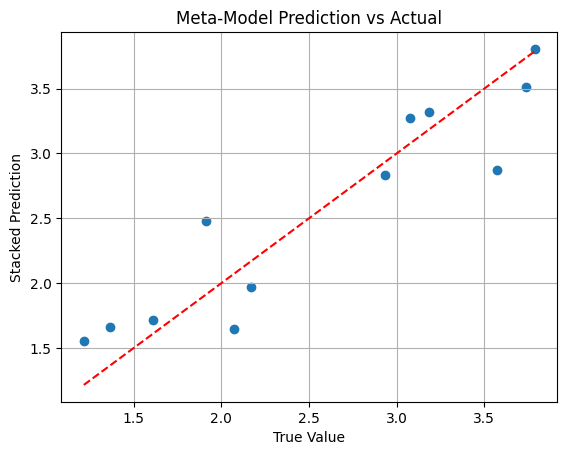

In [14]:

for state in states:
    mask = crop['state_name'] == state
    s = crop[mask].copy().sort_values(by=['year', 'month', 'day'])
    y = s['year'].unique().tolist()
    if len(y) < 10:
        continue
    tmask = s['year'] < y[-1]
    fpmask = s['year'] == y[-1]

    s.drop(columns='state_name', inplace=True)
    df = df_Y[mask].copy().drop(columns='state_name')

    X = s[tmask].copy().set_index(['year', 'month', 'day']).reset_index(drop=True)
    Y = df[tmask].copy().set_index(['year', 'month', 'day']).reset_index(drop=True)
    fpi = s[fpmask].copy().set_index(['year', 'month', 'day']).reset_index(drop=True)
    fpo = df[fpmask].copy().set_index(['year', 'month', 'day']).reset_index(drop=True)
    l = len(X)
    l = int(l/len(y))
    tscv = TimeSeriesSplit(n_splits=5)
    stacked_preds = []

    print(f'\n{state}')

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train = X.loc[train_index]
        y_train = Y.loc[train_index]
        trainlen = len(X_train)

        data_cols = X_train.select_dtypes(include='float64').columns.tolist()
        data_col_num = len(data_cols)

        # ---------- Clean Data (handle NaN/Inf before scaling) ----------
        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
        y_train = y_train.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')

        # ---------- Scaling ----------
        x_scaler.fit(X_train)
        x_train = x_scaler.transform(X_train.astype('float32'))

        window = 364
        y_scaler.fit(y_train.values.reshape(-1, 1))
        y_train_scaled = y_scaler.transform(y_train.values.reshape(-1, 1).astype('float32'))

        # ---------- Sequence creation ----------
        x_train_lstm, y_train_lstm = create_sequences(x_train, y_train_scaled, window=window)
        split_idx = int(0.7 * len(x_train_lstm))
        x_val_lstm = x_train_lstm[split_idx:]
        y_val_lstm = y_train_lstm[split_idx:]
        x_train_lstm = x_train_lstm[:split_idx]
        y_train_lstm = y_train_lstm[:split_idx]

        # ---------- NaN / Inf safety check ----------
        if (np.isnan(x_train_lstm).any() or np.isnan(y_train_lstm).any() or
            np.isnan(x_val_lstm).any() or np.isnan(y_val_lstm).any() or
            np.isinf(x_train_lstm).any() or np.isinf(y_train_lstm).any() or
            np.isinf(x_val_lstm).any() or np.isinf(y_val_lstm).any()):
            raise ValueError(f"NaN or Inf detected in training/validation data for state '{state}' at fold {i}")

        # ---------- Model definition inside try/except ----------
        optimizer = Adam(learning_rate=0.001, clipnorm=1.0)   # Gradient clipping
        model = Sequential(name=f"model_{i}")
        model.add(residual_attention_model(input_shape=(window, data_col_num)))
        model.compile(
            loss='mse',
            metrics=['mae'],
            optimizer=optimizer
        )

        # ---------- Training with NaN-safe callbacks ----------
        from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

        nan_terminate = TerminateOnNaN()
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=0)
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

        model.fit(
            x_train_lstm, y_train_lstm,
            validation_data=(x_val_lstm, y_val_lstm),
            epochs=7,
            batch_size=16,
            callbacks=[nan_terminate, reduce_lr, early_stop],
            verbose=0
        )

        # ---------- Forecasting ----------
        fpi = fpi.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
        fpi_scaled = x_scaler.transform(fpi.astype('float32'))
        fpi_seq, _ = create_sequences(fpi_scaled, np.zeros((len(fpi_scaled), 1)), window=window)

        # Safety check for prediction input
        if np.isnan(fpi_seq).any() or np.isinf(fpi_seq).any():
            raise ValueError(f"NaN or Inf detected in forecast input for state '{state}'")

        y_pred_scaled = model.predict(fpi_seq).mean(axis=1).reshape(-1, 1)
        y_pred = y_scaler.inverse_transform(y_pred_scaled)
        stacked_preds.append(np.mean(y_pred))


    # Final stacked input for this state
    stacked_input = np.column_stack(stacked_preds)
    y_true = fpo.values.mean()

    lpredict[state] = {
        'year': y[-1],
        'stacked_inputs': stacked_input.flatten().tolist(),
        'y_true': float(y_true)
    }

X_meta = []
y_meta = []

for state in lpredict:
    X_meta.append(lpredict[state]['stacked_inputs'])
    y_meta.append(lpredict[state]['y_true'])

X_meta = np.array(X_meta)
y_meta = np.array(y_meta).reshape(-1, 1)

meta_model = Ridge()
meta_model.fit(X_meta, y_meta)
y_pred_meta = meta_model.predict(X_meta)

mse = mean_squared_error(y_meta, y_pred_meta)
mae = mean_absolute_error(y_meta, y_pred_meta)
print(f"\nMeta-Model Evaluation:\nMSE: {mse:.4f}\nMAE: {mae:.4f}")

print("\nState-wise Predictions:")
for i, state in enumerate(lpredict):
    print(f"{state} | Year: {lpredict[state]['year']} | True: {y_meta[i][0]:.4f} | Predicted: {y_pred_meta[i][0]:.4f}")

plt.scatter(y_meta, y_pred_meta)
plt.plot([y_meta.min(), y_meta.max()], [y_meta.min(), y_meta.max()], 'r--')
plt.xlabel("True Value")
plt.ylabel("Stacked Prediction")
plt.title("Meta-Model Prediction vs Actual")
plt.grid(True)
plt.show()


In [1]:
results =  []

for i, state in enumerate(lpredict):
    true_val = y_meta[i][0]
    pred_val = y_pred_meta[i][0]
    year = lpredict[state]['year']

    y_true = np.array([true_val])
    y_pred = np.array([pred_val])

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    results.append({
        'state_name': state,
        'year': year,
        'y_true': float(true_val),
        'y_pred': float(pred_val),
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae)
    })
df = pd.DataFrame(results)
df.to_excel('state_predictions_massor.xlsx', index=False)

NameError: name 'lpredict' is not defined